# Lesson 2 : LangGraph Components

In [33]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=2) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [44]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        logger.info(f"model: {self.model}")

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        logger.info(f"exists_action result: {result}")
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        logger.info(f"state: {state}")
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        logger.info(f"LLM message: {message}")
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        import threading
        print(f"take_action called in thread: {threading.current_thread().name}")
        tool_calls = state['messages'][-1].tool_calls
        results = []
        print(f"take_action called with tool_calls: {tool_calls}")
        for t in tool_calls:
            logger.info(f"Calling: {t}")
            print(f"Calling: {t}") 
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
                logger.info(f"action {t['name']}, result: {result}")
                print(f"action {t['name']}, result: {result}")
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [45]:
prompt = """You are a smart research assistant. Use the search engine to look up information.  \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
os.environ['OPENAI_BASE_URL'] = 'https://key.wenwen-ai.com/v1'
os.environ['OPENAI_API_KEY'] = 'YOUR_API_KEY'
model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
# model = ChatOpenAI(model="yi-large")
abot = Agent(model, [tool], system=prompt)

INFO:__main__:model: bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7e98ec6fedd0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7e98ecaeeb10>, openai_api_key=SecretStr('**********'), openai_proxy='') kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query']}}}]}


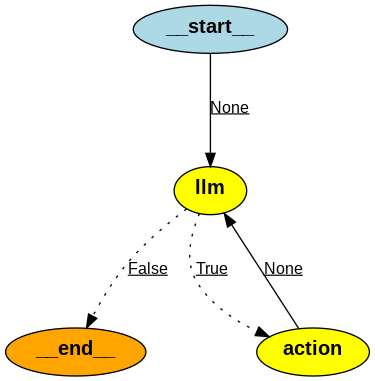

In [11]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [38]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

INFO:__main__:state: {'messages': [HumanMessage(content='What is the weather in sf?')]}


INFO:httpx:HTTP Request: POST https://key.wenwen-ai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:LLM message: content='' additional_kwargs={'tool_calls': [{'id': 'call_Q53LZksF9oeeNO5KSZfX18cv', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 154, 'total_tokens': 175}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_811936bd4f', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-9a9c1513-8987-431c-a9a9-e6aed276127b-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Q53LZksF9oeeNO5KSZfX18cv'}]
INFO:__main__:exists_action result: content='' additional_kwargs={'tool_calls': [{'id': 'call_Q53LZksF9oeeNO5KSZfX18cv', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_m

take_action called in thread: ThreadPoolExecutor-12_0
take_action called with tool_calls: [{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Q53LZksF9oeeNO5KSZfX18cv'}]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Q53LZksF9oeeNO5KSZfX18cv'}


INFO:__main__:action tavily_search_results_json, result: [{'url': 'https://www.wunderground.com/hourly/us/ca/san-francisco/date/2024-6-26', 'content': 'Current Weather for Popular Cities . San Francisco, CA 58 ° F Fair; Manhattan, NY warning 73 ° F Clear; Schiller Park, IL (60176) warning 76 ° F Mostly Cloudy; Boston, MA 65 ° F Cloudy ...'}, {'url': 'https://forecast.weather.gov/zipcity.php?inputstring=San Francisco, CA', 'content': 'Current conditions at SAN FRANCISCO DOWNTOWN (SFOC1) Lat: 37.77056°NLon: 122.42694°WElev: 150.0ft. NA. 57°F. 14°C. ... San Francisco CA 37.77°N 122.41°W (Elev. 131 ft) Last Update: 1:26 pm PDT Jun 20, 2024. Forecast Valid: 2pm PDT Jun 20, 2024-6pm PDT Jun 26, 2024 . Forecast Discussion . Additional Resources. Radar & Satellite Image ...'}]
INFO:__main__:state: {'messages': [HumanMessage(content='What is the weather in sf?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Q53LZksF9oeeNO5KSZfX18cv', 'function': {'arguments': '{"query":"

action tavily_search_results_json, result: [{'url': 'https://www.wunderground.com/hourly/us/ca/san-francisco/date/2024-6-26', 'content': 'Current Weather for Popular Cities . San Francisco, CA 58 ° F Fair; Manhattan, NY warning 73 ° F Clear; Schiller Park, IL (60176) warning 76 ° F Mostly Cloudy; Boston, MA 65 ° F Cloudy ...'}, {'url': 'https://forecast.weather.gov/zipcity.php?inputstring=San Francisco, CA', 'content': 'Current conditions at SAN FRANCISCO DOWNTOWN (SFOC1) Lat: 37.77056°NLon: 122.42694°WElev: 150.0ft. NA. 57°F. 14°C. ... San Francisco CA 37.77°N 122.41°W (Elev. 131 ft) Last Update: 1:26 pm PDT Jun 20, 2024. Forecast Valid: 2pm PDT Jun 20, 2024-6pm PDT Jun 26, 2024 . Forecast Discussion . Additional Resources. Radar & Satellite Image ...'}]
Back to the model!


INFO:httpx:HTTP Request: POST https://key.wenwen-ai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:LLM message: content="The current weather in San Francisco, CA is 58°F with fair conditions. If you'd like more detailed information, you can visit the following link: [San Francisco Weather](https://www.wunderground.com/hourly/us/ca/san-francisco/date/2024-6-26)." response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 436, 'total_tokens': 499}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_44132a4de3', 'finish_reason': 'stop', 'logprobs': None} id='run-ab5750d9-ff80-4c34-9017-ec7b03134f66-0'
INFO:__main__:exists_action result: content="The current weather in San Francisco, CA is 58°F with fair conditions. If you'd like more detailed information, you can visit the following link: [San Francisco Weather](https://www.wunderground.com/hourly/us/ca/san-francisco/date/2024-6-26)." response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_toke

In [39]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Q53LZksF9oeeNO5KSZfX18cv', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 154, 'total_tokens': 175}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_811936bd4f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9a9c1513-8987-431c-a9a9-e6aed276127b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_Q53LZksF9oeeNO5KSZfX18cv'}]),
  ToolMessage(content="[{'url': 'https://www.wunderground.com/hourly/us/ca/san-francisco/date/2024-6-26', 'content': 'Current Weather for Popular Cities . San Francisco, CA 58 ° F Fair; Manhattan, NY warning 73 ° F Clear; Schiller Park, IL (60176) warning 76 ° F Mostly Cloudy; Boston, MA 65 ° F

In [40]:
result['messages'][-1].content

"The current weather in San Francisco, CA is 58°F with fair conditions. If you'd like more detailed information, you can visit the following link: [San Francisco Weather](https://www.wunderground.com/hourly/us/ca/san-francisco/date/2024-6-26)."

## parallel running action
```
take_action called with tool_calls: [ 
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'weather in San Francisco'},
        'id': 'call_isxUnWUmjdy7vkBJkrcYIHSv'
    },
    {
        'name': 'tavily_search_results_json',
        'args': {'query': 'weather in Los Angeles'},
        'id': 'call_q6U5CcmqdZMCvmYpxIjdeYUe'
    }]

```

In [41]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

INFO:__main__:state: {'messages': [HumanMessage(content='What is the weather in SF and LA?')]}
INFO:httpx:HTTP Request: POST https://key.wenwen-ai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:LLM message: content='' additional_kwargs={'tool_calls': [{'id': 'call_isxUnWUmjdy7vkBJkrcYIHSv', 'function': {'arguments': '{"query": "weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_q6U5CcmqdZMCvmYpxIjdeYUe', 'function': {'arguments': '{"query": "weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 156, 'total_tokens': 213}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_811936bd4f', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-f7f1cc8c-e761-4d4d-9204-fd3726a6b81c-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_isxUnWUmjdy7vkBJkrcYIHSv'

take_action called in thread: ThreadPoolExecutor-13_0
take_action called with tool_calls: [{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_isxUnWUmjdy7vkBJkrcYIHSv'}, {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_q6U5CcmqdZMCvmYpxIjdeYUe'}]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_isxUnWUmjdy7vkBJkrcYIHSv'}


INFO:__main__:action tavily_search_results_json, result: [{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1719410957, 'localtime': '2024-06-26 7:09'}, 'current': {'last_updated_epoch': 1719410400, 'last_updated': '2024-06-26 07:00', 'temp_c': 13.3, 'temp_f': 55.9, 'is_day': 1, 'condition': {'text': 'Overcast', 'icon': '//cdn.weatherapi.com/weather/64x64/day/122.png', 'code': 1009}, 'wind_mph': 15.0, 'wind_kph': 24.1, 'wind_degree': 280, 'wind_dir': 'W', 'pressure_mb': 1017.0, 'pressure_in': 30.04, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 93, 'cloud': 100, 'feelslike_c': 12.7, 'feelslike_f': 54.8, 'windchill_c': 11.5, 'windchill_f': 52.7, 'heatindex_c': 12.5, 'heatindex_f': 54.4, 'dewpoint_c': 10.4, 'dewpoint_f': 50.7, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 4.0, 'gust_mph': 19.5, 'gust_kph': 31.3

action tavily_search_results_json, result: [{'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1719410957, 'localtime': '2024-06-26 7:09'}, 'current': {'last_updated_epoch': 1719410400, 'last_updated': '2024-06-26 07:00', 'temp_c': 13.3, 'temp_f': 55.9, 'is_day': 1, 'condition': {'text': 'Overcast', 'icon': '//cdn.weatherapi.com/weather/64x64/day/122.png', 'code': 1009}, 'wind_mph': 15.0, 'wind_kph': 24.1, 'wind_degree': 280, 'wind_dir': 'W', 'pressure_mb': 1017.0, 'pressure_in': 30.04, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 93, 'cloud': 100, 'feelslike_c': 12.7, 'feelslike_f': 54.8, 'windchill_c': 11.5, 'windchill_f': 52.7, 'heatindex_c': 12.5, 'heatindex_f': 54.4, 'dewpoint_c': 10.4, 'dewpoint_f': 50.7, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 4.0, 'gust_mph': 19.5, 'gust_kph': 31.3}}"}, {'url': 

INFO:__main__:action tavily_search_results_json, result: [{'url': 'https://www.accuweather.com/en/us/los-angeles/90012/june-weather/347625', 'content': 'Get the monthly weather forecast for Los Angeles, CA, including daily high/low, historical averages, to help you plan ahead.'}, {'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Los Angeles', 'region': 'California', 'country': 'United States of America', 'lat': 34.05, 'lon': -118.24, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1719411103, 'localtime': '2024-06-26 7:11'}, 'current': {'last_updated_epoch': 1719410400, 'last_updated': '2024-06-26 07:00', 'temp_c': 18.3, 'temp_f': 64.9, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 10, 'wind_dir': 'N', 'pressure_mb': 1015.0, 'pressure_in': 29.97, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 84, 'cloud': 0, 'feelslike_c': 18.3, 'feelslike_

action tavily_search_results_json, result: [{'url': 'https://www.accuweather.com/en/us/los-angeles/90012/june-weather/347625', 'content': 'Get the monthly weather forecast for Los Angeles, CA, including daily high/low, historical averages, to help you plan ahead.'}, {'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Los Angeles', 'region': 'California', 'country': 'United States of America', 'lat': 34.05, 'lon': -118.24, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1719411103, 'localtime': '2024-06-26 7:11'}, 'current': {'last_updated_epoch': 1719410400, 'last_updated': '2024-06-26 07:00', 'temp_c': 18.3, 'temp_f': 64.9, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 10, 'wind_dir': 'N', 'pressure_mb': 1015.0, 'pressure_in': 29.97, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 84, 'cloud': 0, 'feelslike_c': 18.3, 'feelslike_f': 64.9, 'win

INFO:httpx:HTTP Request: POST https://key.wenwen-ai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:LLM message: content='The current weather in San Francisco is overcast with a temperature of 13.3°C (55.9°F) and a wind speed of 15.0 mph. In Los Angeles, the current weather is sunny with a temperature of 18.3°C (64.9°F) and a light wind of 2.2 mph.' response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 1176, 'total_tokens': 1247}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_44132a4de3', 'finish_reason': 'stop', 'logprobs': None} id='run-18898b4f-5ab7-4504-9e8e-8c9be9641a23-0'
INFO:__main__:exists_action result: content='The current weather in San Francisco is overcast with a temperature of 13.3°C (55.9°F) and a wind speed of 15.0 mph. In Los Angeles, the current weather is sunny with a temperature of 18.3°C (64.9°F) and a light wind of 2.2 mph.' response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 1176, 'total_tokens':

In [42]:
result['messages'][-1].content

'The current weather in San Francisco is overcast with a temperature of 13.3°C (55.9°F) and a wind speed of 15.0 mph. In Los Angeles, the current weather is sunny with a temperature of 18.3°C (64.9°F) and a light wind of 2.2 mph.'

## sequentially

the demo in course of Harrison, the code below indeed acted sequentially, however, when I run the same code, it didn't act as expected, but it didn't impact the final result

In [43]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

INFO:__main__:model: bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7e98ecc45cd0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7e98ec725e10>, model_name='gpt-4o', openai_api_key=SecretStr('**********'), openai_proxy='') kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query']}}}]}
INFO:__main__:state: {'messages': [HumanMessage(content='Who won the super bowl in 2024? In what state is the winning team headquarters located? What is the GDP of that state? Answer each question.')]}
INFO:httpx:HTTP Request: POST https://key.wenwen-ai.com/v1/chat/completions "HT

take_action called in thread: ThreadPoolExecutor-14_0
take_action called with tool_calls: [{'name': 'tavily_search_results_json', 'args': {'query': 'Who won the Super Bowl 2024'}, 'id': 'call_qeR97djexvp5tO3TPm1F6Ifz'}]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won the Super Bowl 2024'}, 'id': 'call_qeR97djexvp5tO3TPm1F6Ifz'}


INFO:__main__:action tavily_search_results_json, result: [{'url': 'https://apnews.com/live/super-bowl-2024-updates', 'content': 'Throw in the fact that Chiefs coach Andy Reid will be in his fifth Super Bowl, the third most in NFL history, and has a chance to win a third ring, and the knowledge on the Kansas City sideline will be an advantage too big for the 49ers to overcome.\n She performed in Japan on Saturday night before a flight across nine time zones and the international date line to reach the U.S.\nRihanna performs during halftime of the NFL Super Bowl 57 football game between the Philadelphia Eagles and the Kansas City Chiefs, Sunday, Feb. 12, 2023, in Glendale, Ariz. (AP Photo/David J. Phillip)\n After the teams take the field, Post Malone will perform “America the Beautiful” and Reba McEntire will sing “The Star-Spangled Banner.”\nSan Francisco 49ers quarterback Brock Purdy (13) warms up before the NFL Super Bowl 58 football game against the Kansas City Chiefs, Sunday, Feb. 

action tavily_search_results_json, result: [{'url': 'https://apnews.com/live/super-bowl-2024-updates', 'content': 'Throw in the fact that Chiefs coach Andy Reid will be in his fifth Super Bowl, the third most in NFL history, and has a chance to win a third ring, and the knowledge on the Kansas City sideline will be an advantage too big for the 49ers to overcome.\n She performed in Japan on Saturday night before a flight across nine time zones and the international date line to reach the U.S.\nRihanna performs during halftime of the NFL Super Bowl 57 football game between the Philadelphia Eagles and the Kansas City Chiefs, Sunday, Feb. 12, 2023, in Glendale, Ariz. (AP Photo/David J. Phillip)\n After the teams take the field, Post Malone will perform “America the Beautiful” and Reba McEntire will sing “The Star-Spangled Banner.”\nSan Francisco 49ers quarterback Brock Purdy (13) warms up before the NFL Super Bowl 58 football game against the Kansas City Chiefs, Sunday, Feb. 11, 2024, in L

INFO:httpx:HTTP Request: POST https://key.wenwen-ai.com/v1/chat/completions "HTTP/1.1 503 Service Unavailable"
INFO:openai._base_client:Retrying request to /chat/completions in 0.953028 seconds
INFO:httpx:HTTP Request: POST https://key.wenwen-ai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:LLM message: content='' additional_kwargs={'tool_calls': [{'id': 'call_cdWRAy3JkbHxUrALCS3igWlt', 'function': {'arguments': '{"query": "Kansas City Chiefs headquarters location"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_9b1FWqbPdKvnRQN36plsjzQB', 'function': {'arguments': '{"query": "GDP of Missouri 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 1002, 'total_tokens': 1063}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-b3c50ea8-ba2c-46e7-a871-c10057495931-0' tool_calls=[{'name': 'tavil

take_action called in thread: ThreadPoolExecutor-14_0
take_action called with tool_calls: [{'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_cdWRAy3JkbHxUrALCS3igWlt'}, {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri 2024'}, 'id': 'call_9b1FWqbPdKvnRQN36plsjzQB'}]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_cdWRAy3JkbHxUrALCS3igWlt'}


INFO:__main__:action tavily_search_results_json, result: [{'url': 'https://www.chiefs.com/stadium/suites/contact', 'content': '816-920-4234. mdannewitz@chiefs.nfl.com. The official online home of the Kansas City Chiefs. Your destination for news, videos, photos, podcasts, schedule, community stories, GEHA Field at Arrowhead Stadium information, Cheerleaders, the Chiefs Kingdom Kids program, Tune-in and Radio information, Pro Shop and merchandise, and much more.'}, {'url': 'https://corporateofficeheadquarters.com/kansas-city-chiefs-corporate-office-headquarters/', 'content': 'Kansas City Chiefs Corporate Office: Overview. Kansas City Chiefs Address: One Arrowhead Drive, Kansas City, MO 64129, USA. Kansas City Chiefs Corporate Phone Number: 1-816-920-9300. Ticket Information: 1-816-920-9400. Website: chiefs.com.'}]
INFO:__main__:Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri 2024'}, 'id': 'call_9b1FWqbPdKvnRQN36plsjzQB'}


action tavily_search_results_json, result: [{'url': 'https://www.chiefs.com/stadium/suites/contact', 'content': '816-920-4234. mdannewitz@chiefs.nfl.com. The official online home of the Kansas City Chiefs. Your destination for news, videos, photos, podcasts, schedule, community stories, GEHA Field at Arrowhead Stadium information, Cheerleaders, the Chiefs Kingdom Kids program, Tune-in and Radio information, Pro Shop and merchandise, and much more.'}, {'url': 'https://corporateofficeheadquarters.com/kansas-city-chiefs-corporate-office-headquarters/', 'content': 'Kansas City Chiefs Corporate Office: Overview. Kansas City Chiefs Address: One Arrowhead Drive, Kansas City, MO 64129, USA. Kansas City Chiefs Corporate Phone Number: 1-816-920-9300. Ticket Information: 1-816-920-9400. Website: chiefs.com.'}]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri 2024'}, 'id': 'call_9b1FWqbPdKvnRQN36plsjzQB'}


INFO:__main__:action tavily_search_results_json, result: [{'url': 'https://usafacts.org/topics/economy/state/missouri/', 'content': "Real gross domestic product (GDP) Missouri's share of the US economy. Real gross domestic product (GDP) by industry. ... A majority of funding for the 2024 election — over 65%, or nearly $5.6 billion — comes from political action committees, also known as PACs. Published on May 17, 2024."}, {'url': 'https://www.statista.com/statistics/187908/gdp-of-the-us-federal-state-of-missouri-since-1997/', 'content': 'Published by Statista Research Department , Apr 8, 2024. In 2023, the real gross domestic product (GDP) of Missouri was 344.12 billion U.S. dollars. This is an increase from the previous year ...'}]
INFO:__main__:state: {'messages': [HumanMessage(content='Who won the super bowl in 2024? In what state is the winning team headquarters located? What is the GDP of that state? Answer each question.'), AIMessage(content='', additional_kwargs={'tool_calls': [{

action tavily_search_results_json, result: [{'url': 'https://usafacts.org/topics/economy/state/missouri/', 'content': "Real gross domestic product (GDP) Missouri's share of the US economy. Real gross domestic product (GDP) by industry. ... A majority of funding for the 2024 election — over 65%, or nearly $5.6 billion — comes from political action committees, also known as PACs. Published on May 17, 2024."}, {'url': 'https://www.statista.com/statistics/187908/gdp-of-the-us-federal-state-of-missouri-since-1997/', 'content': 'Published by Statista Research Department , Apr 8, 2024. In 2023, the real gross domestic product (GDP) of Missouri was 344.12 billion U.S. dollars. This is an increase from the previous year ...'}]
Back to the model!


INFO:httpx:HTTP Request: POST https://key.wenwen-ai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:LLM message: content="1. **Who won the Super Bowl in 2024?**\n   - The Kansas City Chiefs won the Super Bowl in 2024.\n\n2. **In what state is the winning team's headquarters located?**\n   - The Kansas City Chiefs' headquarters is located in Missouri. The address is One Arrowhead Drive, Kansas City, MO 64129, USA.\n\n3. **What is the GDP of that state?**\n   - In 2023, the real gross domestic product (GDP) of Missouri was approximately $344.12 billion USD. The 2024 data hasn't been explicitly provided, but it can be inferred to be within a similar range." response_metadata={'token_usage': {'completion_tokens': 135, 'prompt_tokens': 1458, 'total_tokens': 1593}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'stop', 'logprobs': None} id='run-5a583d41-c8c3-479d-95dd-556162970220-0'
INFO:__main__:exists_action result: content="1. **Who won the Super 

In [46]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**
   - The Kansas City Chiefs won the Super Bowl in 2024.

2. **In what state is the winning team's headquarters located?**
   - The Kansas City Chiefs' headquarters is located in Missouri. The address is One Arrowhead Drive, Kansas City, MO 64129, USA.

3. **What is the GDP of that state?**
   - In 2023, the real gross domestic product (GDP) of Missouri was approximately $344.12 billion USD. The 2024 data hasn't been explicitly provided, but it can be inferred to be within a similar range.
